## Capstone 2. Predicting Circular Dichorism Spectrum Features from Amino Acid Sequence
### Modeling
Data is coming from the Protein Circular Dichroism Data Bank (https://pcddb.cryst.bbk.ac.uk/). Citation information: The PCDDB (protein circular dichroism data bank): A bioinformatics resource for protein characterisations and methods development. Ramalli SG, Miles AJ, Janes RW, Wallace BA., J Mol Biol (2022)
<p>
During EDA, three different modeling algorithms showed the most promise:<br>
    - RandomForestClassifier<br>
    - AdaBoostClassifier<br>
    - SVC (Support Vector Classification<br>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import loguniform
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
# unpickle dataframes
aa_means = pd.read_pickle('aa_means.pkl')
aa_sums = pd.read_pickle('aa_sums.pkl')
target_df_cat = pd.read_pickle('target_df_cat.pkl')

### Identifying hyperparameters for the three models

I will individually tune the hyperparameters for the three algorithms identified as the most promising during EDA. Then, I will use the best of the hyperparameters identified for each to compare the models' performances to one another. Since there are multiple (3) target variables, we will start out by focusing on alpha helix, which should be the strongest signal and have relatively balanced classes. Models will need to be evaluated for random coil as well, which is the most class-imbalanced of the three.

In [3]:
aa_df = aa_means.merge(aa_sums, on = 'PCDDB ID', suffixes = ('_means', '_sums'))
X = aa_df.drop('PCDDB ID', axis = 1)
y = target_df_cat.drop('PCDDB ID', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
# hyperparameter tuning - SVC
param_grid_svc = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.1, 1, 10, 100]
}

In [5]:
grid_svc_alpha = GridSearchCV(SVC(), param_grid_svc, verbose = 3).fit(X_train, y_train['alpha'].values)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ................C=0.1, gamma=0.001;, score=0.671 total time=   0.0s
[CV 2/5] END ................C=0.1, gamma=0.001;, score=0.722 total time=   0.0s
[CV 3/5] END ................C=0.1, gamma=0.001;, score=0.671 total time=   0.0s
[CV 4/5] END ................C=0.1, gamma=0.001;, score=0.646 total time=   0.0s
[CV 5/5] END ................C=0.1, gamma=0.001;, score=0.734 total time=   0.0s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.671 total time=   0.0s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.722 total time=   0.0s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.671 total time=   0.0s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.620 total time=   0.0s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.734 total time=   0.0s
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.671 total time=   0.0s
[CV 2/5] END ....................C=0.1, gamma=1

In [6]:
svc_params = grid_svc_alpha.best_params_
print("Best parameters for identifying alpha helices with SVC:")
print(svc_params)

Best parameters for identifying alpha helices with SVC:
{'C': 1, 'gamma': 0.001}


In [7]:
# hyperparameter tuning - Random Forest
param_grid_rfc = {
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
     'min_samples_split': [2, 5, 10],
     'bootstrap': [True, False],
     'min_samples_leaf': [1, 2, 4],
}

In [8]:
random_rfc_alpha = RandomizedSearchCV(RandomForestClassifier(), param_grid_rfc, verbose = 3).fit(X_train, y_train['alpha'].values)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=True, max_depth=90, min_samples_leaf=1, min_samples_split=10, n_estimators=1400;, score=0.734 total time=   1.3s
[CV 2/5] END bootstrap=True, max_depth=90, min_samples_leaf=1, min_samples_split=10, n_estimators=1400;, score=0.772 total time=   1.3s
[CV 3/5] END bootstrap=True, max_depth=90, min_samples_leaf=1, min_samples_split=10, n_estimators=1400;, score=0.759 total time=   1.3s
[CV 4/5] END bootstrap=True, max_depth=90, min_samples_leaf=1, min_samples_split=10, n_estimators=1400;, score=0.772 total time=   1.3s
[CV 5/5] END bootstrap=True, max_depth=90, min_samples_leaf=1, min_samples_split=10, n_estimators=1400;, score=0.722 total time=   1.2s
[CV 1/5] END bootstrap=True, max_depth=70, min_samples_leaf=2, min_samples_split=5, n_estimators=2000;, score=0.734 total time=   1.8s
[CV 2/5] END bootstrap=True, max_depth=70, min_samples_leaf=2, min_samples_split=5, n_estimators=2000;, score=0.785 total ti

In [11]:
rfc_params = random_rfc_alpha.best_params_
print("Best parameters for identifying alpha helices with Random Forest:")
print(rfc_params)

Best parameters for identifying alpha helices with Random Forest:
{'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 80, 'bootstrap': True}


In [12]:
# hyperparameter tuning - Ada Boost
param_grid_abc = {
    'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 30],
    'learning_rate': [0.1, 0.5, 1, 2, 3, 4, 6, 8],
    'algorithm': ['SAMME', 'SAMME.R']
}

In [13]:
grid_ada_alpha = GridSearchCV(AdaBoostClassifier(), param_grid_abc, verbose = 3).fit(X_train, y_train['alpha'].values)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits
[CV 1/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=1;, score=0.709 total time=   0.0s
[CV 2/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=1;, score=0.734 total time=   0.0s
[CV 3/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=1;, score=0.684 total time=   0.0s
[CV 4/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=1;, score=0.620 total time=   0.0s
[CV 5/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=1;, score=0.671 total time=   0.0s
[CV 1/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=2;, score=0.709 total time=   0.0s
[CV 2/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=2;, score=0.709 total time=   0.0s
[CV 3/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=2;, score=0.684 total time=   0.0s
[CV 4/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=2;, score=0.620 total time=   0.0s
[CV 5/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=2

In [14]:
params_ada = grid_ada_alpha.best_params_
print("Best parameters for identifying alpha helices with AdaBoost:")
print(params_ada)

Best parameters for identifying alpha helices with AdaBoost:
{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 10}


### Comparing the three models with the identified hyperparameters.

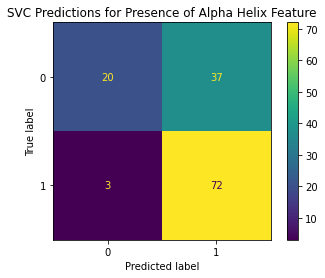

              precision    recall  f1-score   support

       False       0.87      0.35      0.50        57
        True       0.66      0.96      0.78        75

    accuracy                           0.70       132
   macro avg       0.77      0.66      0.64       132
weighted avg       0.75      0.70      0.66       132



In [20]:
svc_a = SVC(**svc_params)
svc_a.fit(X_train, y_train['alpha'].values)
alpha_pred = svc_a.predict(X_test)
cm_svc_a = confusion_matrix(y_test['alpha'].values, alpha_pred)
ConfusionMatrixDisplay(cm_svc_a).plot()
plt.title("SVC Predictions for Presence of Alpha Helix Feature")
plt.show()

print(classification_report(y_test['alpha'].values, alpha_pred))

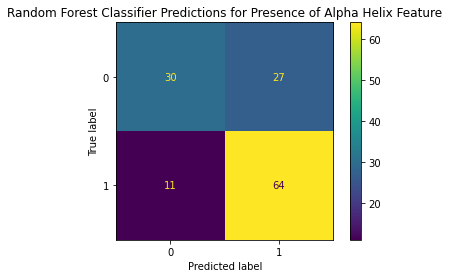

              precision    recall  f1-score   support

       False       0.73      0.53      0.61        57
        True       0.70      0.85      0.77        75

    accuracy                           0.71       132
   macro avg       0.72      0.69      0.69       132
weighted avg       0.72      0.71      0.70       132



In [21]:
rfc_a = RandomForestClassifier(**rfc_params)
rfc_a.fit(X_train, y_train['alpha'].values)
alpha_pred_rfc = rfc_a.predict(X_test)
cm_rfc_a = confusion_matrix(y_test['alpha'].values, alpha_pred_rfc)
ConfusionMatrixDisplay(cm_rfc_a).plot()
plt.title("Random Forest Classifier Predictions for Presence of Alpha Helix Feature")
plt.show()

print(classification_report(y_test['alpha'].values, alpha_pred_rfc))

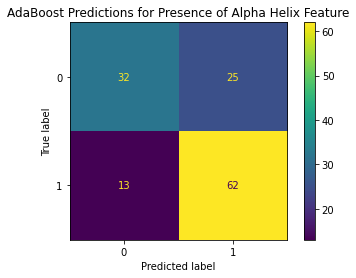

              precision    recall  f1-score   support

       False       0.71      0.56      0.63        57
        True       0.71      0.83      0.77        75

    accuracy                           0.71       132
   macro avg       0.71      0.69      0.70       132
weighted avg       0.71      0.71      0.71       132



In [22]:
ada_a = AdaBoostClassifier(**params_ada)
ada_a.fit(X_train, y_train['alpha'].values)
alpha_pred_ada = ada_a.predict(X_test)
cm_ada_a = confusion_matrix(y_test['alpha'].values, alpha_pred_ada)
ConfusionMatrixDisplay(cm_ada_a).plot()
plt.title("AdaBoost Predictions for Presence of Alpha Helix Feature")
plt.show()

print(classification_report(y_test['alpha'].values, alpha_pred_ada))

It seems like all of the models are quite similar, with recall for False coming up as the weakest point for all of them. However, of the three, Random Forest seems like a slight standout, so this is the model that we will move forward with.

### Simplify features

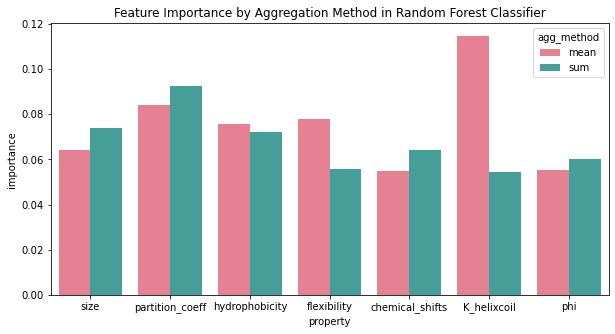

In [23]:
# See if we can simplify features
fi = rfc_a.feature_importances_
properties = list(aa_means.columns[:-1])*2
agg_method = ['mean'] * 7 + ['sum'] * 7

feat_import = pd.DataFrame({'property': properties, 'agg_method': agg_method, 'importance': fi})

plt.figure(figsize = (10, 5))
sns.barplot(feat_import, x = 'property', y = 'importance', hue = 'agg_method', palette = 'husl')
plt.title("Feature Importance by Aggregation Method in Random Forest Classifier")
plt.show()

For everything except for helical coil propensity, it seems like the total sum matters slightly more than the average value. So, let's see what the model outcomes look like for sums only.

In [24]:
X = aa_sums.drop('PCDDB ID', axis = 1)
y = target_df_cat.drop('PCDDB ID', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

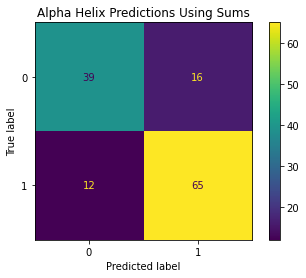

              precision    recall  f1-score   support

       False       0.76      0.71      0.74        55
        True       0.80      0.84      0.82        77

    accuracy                           0.79       132
   macro avg       0.78      0.78      0.78       132
weighted avg       0.79      0.79      0.79       132



In [25]:
rfc_alpha = RandomForestClassifier(**rfc_params)
rfc_alpha.fit(X_train, y_train['alpha'].values)
alpha_pred = rfc_alpha.predict(X_test)
cm_alpha = confusion_matrix(y_test['alpha'].values, alpha_pred)
ConfusionMatrixDisplay(cm_alpha).plot()
plt.title("Alpha Helix Predictions Using Sums")
plt.show()

print(classification_report(y_test['alpha'].values, alpha_pred))

That looks basically the same as with both means and sums! Let's look at what this looks like for the other types of secondary structures.

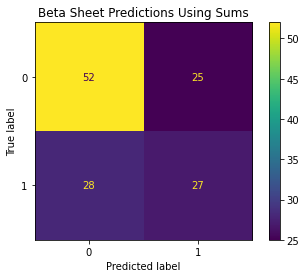

              precision    recall  f1-score   support

       False       0.65      0.68      0.66        77
        True       0.52      0.49      0.50        55

    accuracy                           0.60       132
   macro avg       0.58      0.58      0.58       132
weighted avg       0.60      0.60      0.60       132



In [26]:
rfc_beta = RandomForestClassifier(**rfc_params)
rfc_beta.fit(X_train, y_train['beta'].values)
beta_pred = rfc_beta.predict(X_test)
cm_beta = confusion_matrix(y_test['beta'].values, beta_pred)
ConfusionMatrixDisplay(cm_beta).plot()
plt.title("Beta Sheet Predictions Using Sums")
plt.show()

print(classification_report(y_test['beta'].values, beta_pred))

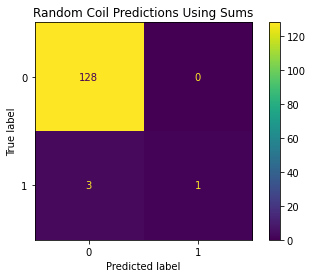

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       128
        True       1.00      0.25      0.40         4

    accuracy                           0.98       132
   macro avg       0.99      0.62      0.69       132
weighted avg       0.98      0.98      0.97       132



In [27]:
rfc_randcoil = RandomForestClassifier(**rfc_params)
rfc_randcoil.fit(X_train, y_train['random_coil'].values)
randcoil_pred = rfc_randcoil.predict(X_test)
cm_randcoil = confusion_matrix(y_test['random_coil'].values, randcoil_pred)
ConfusionMatrixDisplay(cm_randcoil).plot()
plt.title("Random Coil Predictions Using Sums")
plt.show()

print(classification_report(y_test['random_coil'].values, randcoil_pred))

Since random coil has such a class imbalance, the model not able to predict instances of it occurring at all. Class weighting can help address this imbalance some:

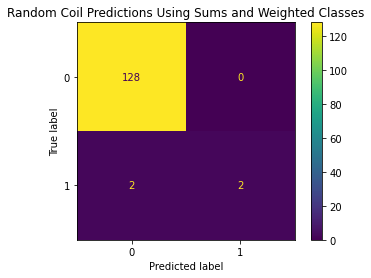

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       128
        True       1.00      0.50      0.67         4

    accuracy                           0.98       132
   macro avg       0.99      0.75      0.83       132
weighted avg       0.99      0.98      0.98       132



In [28]:
rfcWC_randcoil = RandomForestClassifier(**rfc_params, class_weight ={0:1, 1: 10})
rfcWC_randcoil.fit(X_train, y_train['random_coil'].values)
randcoilWC_pred = rfcWC_randcoil.predict(X_test)
cm_randcoilWC = confusion_matrix(y_test['random_coil'].values, randcoilWC_pred)
ConfusionMatrixDisplay(cm_randcoilWC).plot()
plt.title("Random Coil Predictions Using Sums and Weighted Classes")
plt.show()

print(classification_report(y_test['random_coil'].values, randcoilWC_pred))

That is a bit better! Will use this weighting for random coil as our default.

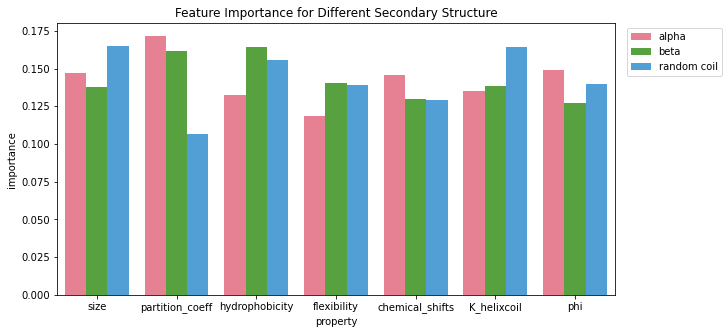

In [29]:
fi_alpha = rfc_alpha.feature_importances_
fi_beta = rfc_beta.feature_importances_
fi_randcoil = rfcWC_randcoil.feature_importances_

properties = list(X.columns)

df_alpha = pd.DataFrame({'property': properties, 'importance': fi_alpha, 'feature': 'alpha'})
df_beta = pd.DataFrame({'property': properties, 'importance': fi_beta, 'feature': 'beta'})
df_randcoil = pd.DataFrame({'property': properties, 'importance': fi_randcoil, 'feature': 'random coil'})

df_fi = pd.concat([df_alpha, df_beta, df_randcoil])

plt.figure(figsize = (10, 5))
sns.barplot(df_fi, x = 'property', y = 'importance', hue = 'feature', palette = 'husl')
plt.title("Feature Importance for Different Secondary Structure")
plt.legend(bbox_to_anchor = (1.2, 1))
plt.show()

### Hydrophobicity sum as sole explanatory variable

Based on the above, it seems like hydrophobicity (and closely related partition coefficient) might have the most importance. What does the model performance look like if we use only the hydrophobicity sum as input?

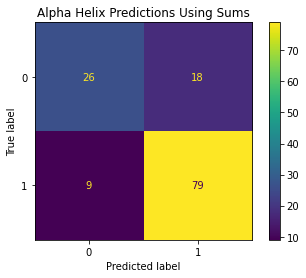

              precision    recall  f1-score   support

       False       0.74      0.59      0.66        44
        True       0.81      0.90      0.85        88

    accuracy                           0.80       132
   macro avg       0.78      0.74      0.76       132
weighted avg       0.79      0.80      0.79       132



In [44]:
X = aa_sums[['hydrophobicity']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

rfc_alpha = RandomForestClassifier(**rfc_params)
rfc_alpha.fit(X_train, y_train['alpha'].values)
alpha_pred = rfc_alpha.predict(X_test)
cm_alpha = confusion_matrix(y_test['alpha'].values, alpha_pred)
ConfusionMatrixDisplay(cm_alpha).plot()
plt.title("Alpha Helix Predictions Using Sums")
plt.show()

print(classification_report(y_test['alpha'].values, alpha_pred))

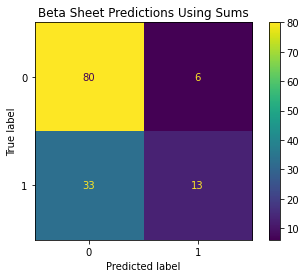

              precision    recall  f1-score   support

       False       0.71      0.93      0.80        86
        True       0.68      0.28      0.40        46

    accuracy                           0.70       132
   macro avg       0.70      0.61      0.60       132
weighted avg       0.70      0.70      0.66       132



In [45]:
rfc_beta = RandomForestClassifier(**rfc_params)
rfc_beta.fit(X_train, y_train['beta'].values)
beta_pred = rfc_beta.predict(X_test)
cm_beta = confusion_matrix(y_test['beta'].values, beta_pred)
ConfusionMatrixDisplay(cm_beta).plot()
plt.title("Beta Sheet Predictions Using Sums")
plt.show()

print(classification_report(y_test['beta'].values, beta_pred))

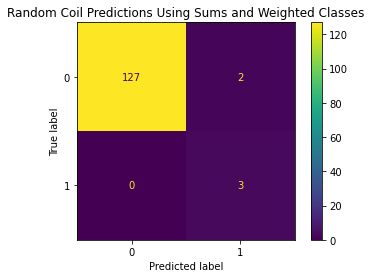

              precision    recall  f1-score   support

       False       1.00      0.98      0.99       129
        True       0.60      1.00      0.75         3

    accuracy                           0.98       132
   macro avg       0.80      0.99      0.87       132
weighted avg       0.99      0.98      0.99       132



In [46]:
rfcWC_randcoil = RandomForestClassifier(**rfc_params, class_weight ={0:1, 1: 10})
rfcWC_randcoil.fit(X_train, y_train['random_coil'].values)
randcoilWC_pred = rfcWC_randcoil.predict(X_test)
cm_randcoilWC = confusion_matrix(y_test['random_coil'].values, randcoilWC_pred)
ConfusionMatrixDisplay(cm_randcoilWC).plot()
plt.title("Random Coil Predictions Using Sums and Weighted Classes")
plt.show()

print(classification_report(y_test['random_coil'].values, randcoilWC_pred))

### Conclusions

The sum of the hydrophobicity index serves as well as a predictor as using all of the properties we looked at. This is true for alpha helices, beta sheets, and random coils, although each has its own weaknesses.<p>

The best results were seen with a Random Forest Classifier with the parameters below and, for random coil, `class_weight ={0:1, 1: 10}`.

In [47]:
print(rfc_params)

{'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 80, 'bootstrap': True}
